# 04. Comparison of in vivo (scRNA-seq) and in vitro (bulk RNA-seq) NMF-derived programs

Here, NMF is performed on bulk sequencing data from MOC1 cell lines treated with chronic interferon or vehicle, given a 2-week washout, and re-exposed to interferon for 6 hours. These in-vitro derived NMF programs are then compared to the in vivo program derived from MOC1res/MOC1sens/MOC1iso tumors.

In [21]:
import pandas as pd
import numpy as np
from sklearn.decomposition import NMF
import seaborn as sns
import matplotlib.pyplot as plt
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scanpy as sc
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib as mpl
from scipy.stats import pearsonr

## 0. Read in counts and format

In [2]:
counts = pd.read_csv('/path/to/MOC1_cIFNG_Elf3_counts.csv')
counts = counts.rename(columns={'Unnamed: 0': 'Geneid'})

In [3]:
counts = counts.set_index('Geneid')
counts

,RS42B_1,RS42B_2,RS42B_3,RS42B_4,RS42B_5,RS42B_6,RS42B_7,RS42B_8,RS42B_9,RS42B_10,...,RS42B_23,RS42B_24,RS42B_25,RS42B_26,RS42B_27,RS42B_28,RS42B_29,RS42B_30,RS42B_31,RS42B_32
Geneid,,,,,,,,,,,,,,,,,,,,,
4933401J01Rik,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm26206,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Xkr4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm18956,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Gm37180,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Gm28301,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Mid1-ps1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
G530011O06Riky,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
counts = counts[counts.sum(axis = 1) > 10]
counts.index[counts.index.duplicated()]
counts = counts[~counts.index.duplicated()]
counts = counts.T

In [5]:
metadata = pd.read_csv('/path/to/counts_manifest.csv')
metadata = metadata.set_index('sample')
metadata = metadata[metadata.experiment == 'MOC1_cIFNG_Elf3']
metadata = metadata.drop(columns=['experiment'])

## 1. Perform DESeq2 to obtain normalized counts matrix

In [8]:
dds = DeseqDataSet(counts=counts,
            metadata=metadata,
            design_factors="condition")

/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/pydeseq2/dds.py:264: UserWarning: Some factor levels in the design contain underscores ('_').
                    They will be converted to hyphens ('-').
  self.obsm["design_matrix"] = build_design_matrix(


In [9]:
dds.deseq2()

Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 0.88 seconds.

Fitting dispersion trend curve...
... done in 0.21 seconds.

Fitting MAP dispersions...
... done in 1.29 seconds.

Fitting LFCs...
... done in 0.91 seconds.

Calculating cook's distance...
... done in 0.02 seconds.

Replacing 0 outlier genes.



In [10]:
dds

AnnData object with n_obs × n_vars = 32 × 14955
    obs: 'condition'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks'

In [11]:
dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

## 2. Perform NMF on in vitro bulk RNA-seq data

W shape: (16, 5), H shape: (5, 5000)
Reconstruction error: 29.5407


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 500 reached. Increase it to improve convergence.
  warnings.warn(


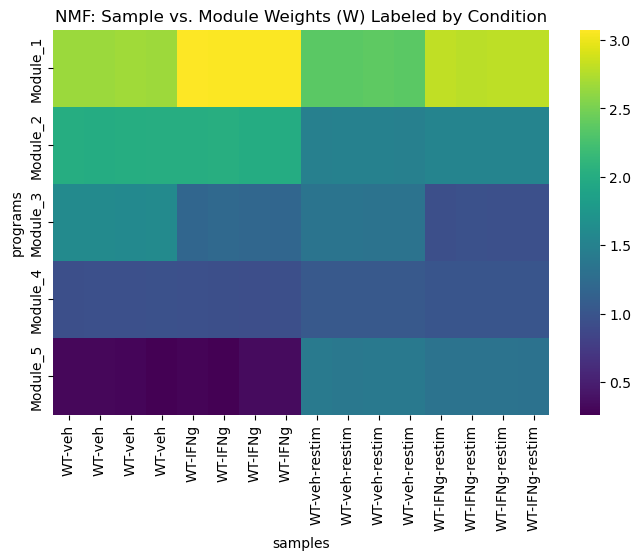

In [29]:
# select samples from specific experimental conditions
mask = norm_counts['condition'].isin(['WT-veh','WT-IFNg','WT-veh-restim','WT-IFNg-restim'])
df_expr = norm_counts.loc[mask, :]

# save condition labels and drop them from the expression matrix
conditions = df_expr['condition'].copy()
df_expr = df_expr.drop(columns=['condition'])

# (1) find highly-variable genes and subset the expression matrix
# calculate gene-wise mean and variance across samples
gene_means = df_expr.mean(axis=0)
gene_vars = df_expr.var(axis=0)

# remove genes with zero mean to avoid numerical issues
nonzero_mask = (gene_means > 0)
mu = gene_means[nonzero_mask].values
var = gene_vars[nonzero_mask].values
genes_nonzero = df_expr.columns[nonzero_mask]

# fit a quadratic curve to estimate expected variance as a function of mean
coeff = np.polyfit(mu, var, deg=2)

def poly_var_est(x, c=coeff):
    return c[0]*x*x + c[1]*x + c[2]

# compute a v-score for each gene based on deviation from expected variance
var_est = poly_var_est(mu, coeff)
vscore = (var - var_est) / (mu + 1e-9)

# rank genes by v-score and select the top most variable genes
ranked_idx = np.argsort(-vscore)
H = 5000  # number of genes to retain
top_genes = genes_nonzero[ranked_idx[:H]]

# subset expression matrix to top variable genes
df_expr = df_expr[top_genes]

# (2) apply log transformation to stabilize variance
df_expr = np.log2(df_expr + 1)

# (3) run non-negative matrix factorization with k components
k = 5
model = NMF(n_components=k, init='random', random_state=42, max_iter=500)
W = model.fit_transform(df_expr)  # sample × module weights
H = model.components_             # module × gene weights

print(f"W shape: {W.shape}, H shape: {H.shape}")
print(f"Reconstruction error: {model.reconstruction_err_:.4f}")

# convert W and H to labeled DataFrames
df_W = pd.DataFrame(W, columns=[f"Module_{i+1}" for i in range(k)], index=df_expr.index)
df_W['condition'] = conditions.loc[df_W.index]
df_W.set_index('condition', inplace=True)

df_H = pd.DataFrame(H, columns=df_expr.columns, index=[f"Module_{i+1}" for i in range(k)])

# plot heatmap of sample weights per module, grouped by condition
plt.figure(figsize=(8, 5))
sns.heatmap(df_W.T, cmap='viridis')
plt.title("NMF: Sample vs. Module Weights (W) Labeled by Condition")
plt.xlabel("samples")
plt.ylabel("programs")
plt.show()


In [13]:
# save the top 1000 genes for each program ranked by their loadings in descending order
# output the top 20 genes for each program
top_n = 1000

# Create a DataFrame with a fixed index = 1..top_n (one row per rank)
df_top_genes = pd.DataFrame(index=range(1, top_n+1))

# Iterate over each module to get top 100 gene names (sorted by loading desc)
for module in df_H.index:
    # Sort the row for this module by descending loading
    sorted_genes = df_H.loc[module].sort_values(ascending=False)
    
    # Take the top N gene names (the .index of the sorted Series)
    top_gene_names = sorted_genes.head(top_n).index
    
    # Store these gene names as a column in df_top_genes
    df_top_genes[module] = list(top_gene_names)

df_top_genes.head(20)


,Module_1,Module_2,Module_3,Module_4,Module_5
1,Cxcl5,Ubb,Ckb,Tspan31,Iigp1
2,Slpi,Krt6a,Gprc5c,Them6,Irgm2
3,Ppbp,Sec61b,Fn1,Ube3c,Igtp
4,Lgals7,Acly,Moxd1,Actr10,Gbp2
5,Cxcl1,Cbx6,Sparc,Lamc1,Gbp4
6,Krt5,Cavin1,Abcg2,Abhd16a,Ifi47
7,Krt16,Ncaph2,Tmsb4x,U2af1,Cxcl10
8,Psca,Fdps,Ccnd2,Picalm,Irf8
9,Akr1b8,Lsm8,Unc5b,Rplp2,Gbp7
10,Rps2,Oaz1,Tnc,Hook1,Tgtp1


## 3. Compare in vitro NMF programs to in vivo NMF programs

In [16]:
# this is the H matrix from above
df_H_bulk = df_H

In [17]:
# read in H matrix from single-cell NMF
df_H_sc = pd.read_csv("/path/to/cNMF_outs_run2/cNMF_run2/cNMF_run2.spectra.k_17.dt_0_05.consensus.txt",sep='\t', index_col=0)

In [18]:
# restrict sc programs to those identified in malignant cells (exclude immune programs), and remove k=17 bc unclassified and too few cells
df_H_sc = df_H_sc[df_H_sc.index.isin([1,8,5,3,7,2,4])]

In [19]:
# restrict to only the IFN inducible programs
df_H_bulk = df_H_bulk[df_H_bulk.index.isin(['Module_1','Module_5'])]

In [20]:
# 3) Intersection of genes
common = df_H_bulk.columns.intersection(df_H_sc.columns)
Hb = df_H_bulk[common].values   # shape (5, G)
Hs = df_H_sc  [common].values   # shape (k, G)

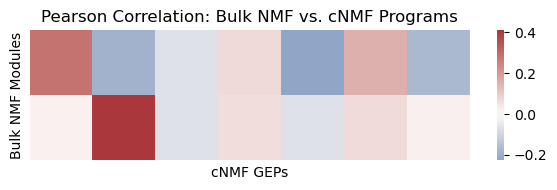

In [23]:
# identify common genes between in vitro and in vivo datasets
common_genes = df_H_bulk.columns.intersection(df_H_sc.columns)
bulk_mat = df_H_bulk[common_genes]
sc_mat   = df_H_sc  [common_genes]

# compute pearson correlation matrix
mods = bulk_mat.index
geps = sc_mat.index
pearson_mat = np.zeros((len(mods), len(geps)))

for i, mod in enumerate(mods):
    for j, gep in enumerate(geps):
        pearson_mat[i, j] = pearsonr(bulk_mat.loc[mod], sc_mat.loc[gep])[0]

df_pearson = pd.DataFrame(pearson_mat, index=mods, columns=geps)

# custom order for matrix columns
custom_col_order = [8,5,7,1,2,3,4]  # example
df_pearson = df_pearson[custom_col_order]  # Reorder columns

# plot heatmap
plt.figure(figsize=(6, 2))
sns.heatmap(df_pearson, annot=False, cmap="vlag", center=0, fmt=".2f")
plt.title("Pearson Correlation: Bulk NMF vs. cNMF Programs")
plt.xlabel("cNMF GEPs")
plt.ylabel("Bulk NMF Modules")
plt.xticks([])  
plt.yticks([])  
plt.tight_layout()
#plt.savefig('program_corr.png', dpi=300)
plt.show()


In [25]:
# report correlation values
df_pearson

,8,5,7,1,2,3,4
Module_1,0.284509,-0.188789,-0.067388,0.069255,-0.227605,0.155341,-0.168901
Module_5,0.020691,0.410610,-0.065920,0.061743,-0.070530,0.066517,0.026008


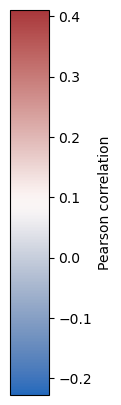

In [27]:
# create figure-quality color bar
def make_colorbar(cmap, vmin, vmax, label="", save_path=None):
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    fig, ax = plt.subplots(figsize=(.5, 5))
    cb = mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm)
    cb.set_label(label)

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
        
make_colorbar(cmap='vlag', vmin=df_pearson.min().min(), vmax=df_pearson.max().max(), label='Pearson correlation')